In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
file_path = '/content/drive/My Drive/Colab Notebooks/dl-albanian/AlbAna-simplified.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, header=0)

In [3]:
print(df.head())
num_rows, num_cols = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

                                             Comment  Annotation
0                                     Dorentina TBT            0
1  Mbyllni kufijte sot. Sitiata ka me u ba shume ...           2
2  Mbyllni kufit ashtu mund te jemi te sigurte, p...           0
3  Pse nuk po  i  mbyllni  kufijte,  sonte  ne  q...           0
4  Mos  harroni  qe  kufinjte  tane  jane  te  ha...           0
Number of rows: 10742
Number of columns: 2


In [4]:
#Create lists of Annotations and Comments
#==============================================================================
y, docs = [], []

for annotation in df['Annotation']:
    # Append each annotation value to the list
    y.append(annotation)

for comment in df['Comment']:
    # Append each comment to the list
    docs.append(comment)

average = sum(len(doc) for doc in docs) / len(docs)
print (average)


84.7819772854217


In [5]:
#Encode class values as integers
#==============================================================================
from sklearn.preprocessing import LabelEncoder
from keras import utils

encoder = LabelEncoder()

encoder.fit(y)

encoded_y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
if encoded_y.size == 0:
    print("Error: encoded_y is empty. Please check the input data.")
else:
    # Convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = utils.to_categorical(encoded_y)

In [6]:
#Define plot_history function
#==============================================================================
import matplotlib.pyplot as plt

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [7]:
#plot confusion_matrix function
#==============================================================================
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [24]:
#Define full_multiclass_report which prints classification report
# updated
#==============================================================================
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def full_multiclass_report(model, x, y_true, classes, batch_size=64, binary=False):
    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true, axis=1)

    # 2. Predict probabilities for each class
    y_pred_prob = model.predict(x, batch_size=batch_size)

    # 3. Convert predicted probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)

    # 4. Print accuracy score
    print("Accuracy : " + str(accuracy_score(y_true, y_pred)))
    print("")

    # 5. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))

    # 6. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix, classes=classes)


In [25]:
#Input parameters
#==============================================================================
MAX_SEQUENCE_LENGTH = 20
MAX_NB_WORDS = 2000
EMBEDDING_DIM = 300

In [26]:
#Create a tokenizer
#==============================================================================
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, lower=True )

tokenizer.fit_on_texts(docs)

sequences = tokenizer.texts_to_sequences(docs)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

# convert text to sequence of tokens and pad them to ensure equal length vectors
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 22587 unique tokens.


In [27]:
#Training, testing and validation
#==============================================================================
from sklearn.model_selection import train_test_split
seed =1000

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, train_size=0.7, random_state=seed)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.7, random_state=seed)

In [13]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=56a6df775e370672359e13828bf48e1ac2fc3a1455b77360097fdaadbed3291d
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [28]:
# Pretrained FastText embeddings
#==============================================================================
print('loading FastText word embeddings...')

embeddings_index = {}
words_not_found = []

import fasttext
import fasttext.util

ftpath = '/content/drive/My Drive/Colab Notebooks/dl-albanian/cc.sq.300.vec'
f=open (ftpath, "r", encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('Number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

loading FastText word embeddings...
Found 1167010 word vectors.
Number of null word embeddings: 7850


In [29]:
!pip install keras_self_attention

ERROR: Operation cancelled by user


In [30]:
#Build LSTM model
#==============================================================================
from tensorflow import keras
from keras import layers, activations
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, LSTM,  SpatialDropout1D
from keras.layers import Input, Flatten, Lambda, Dropout
from keras.layers import TimeDistributed, Bidirectional
from keras_self_attention import SeqSelfAttention

model = Sequential()

'''
model.add(layers.Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
'''
model.add(layers.Embedding(len(word_index),  EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))




model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(32, return_sequences=True)))

model.add(SeqSelfAttention( attention_width=8, attention_activation='sigmoid', name='Attention',))

model.add(Flatten())

model.add(Dense(3, activation='softmax'))


model.summary()



model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           6776100   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 20, 300)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 20, 64)            85248     
 onal)                                                           
                                                                 
 Attention (SeqSelfAttentio  (None, 20, 64)            4161      
 n)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/5
21/21 [==============================] - 8s 158ms/step - loss: 0.9609 - accuracy: 0.5763 - val_loss: 0.9040 - val_accuracy: 0.5887
Epoch 2/5
21/21 [==============================] - 2s 103ms/step - loss: 0.8134 - accuracy: 0.6396 - val_loss: 0.7709 - val_accuracy: 0.6525
Epoch 3/5
21/21 [==============================] - 2s 96ms/step - loss: 0.6046 - accuracy: 0.7530 - val_loss: 0.6787 - val_accuracy: 0.7141
Epoch 4/5
21/21 [==============================] - 2s 98ms/step - loss: 0.4654 - accuracy: 0.8225 - val_loss: 0.7165 - val_accuracy: 0.7238
Epoch 5/5
21/21 [==============================] - 2s 103ms/step - loss: 0.3944 - accuracy: 0.8482 - val_loss: 0.7558 - val_accuracy: 0.7270


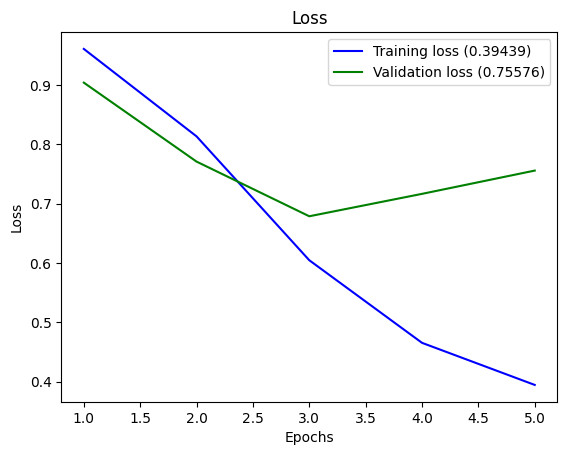

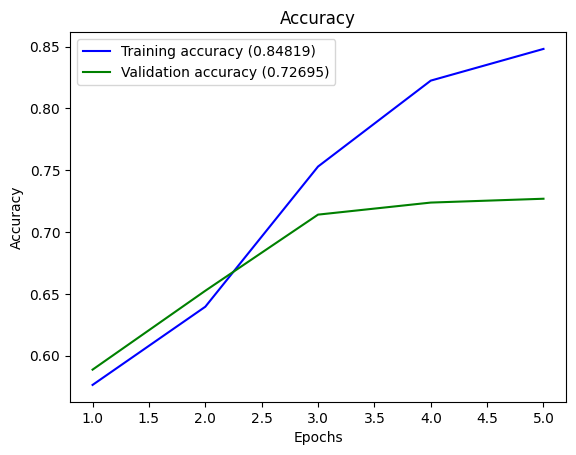

36/36 [==============================] - 1s 10ms/step
Accuracy : 0.7269503546099291

Classification Report
              precision    recall  f1-score   support

           0     0.7301    0.8683    0.7932      1268
           1     0.7849    0.5810    0.6677       358
           2     0.6853    0.5254    0.5948       630

    accuracy                         0.7270      2256
   macro avg     0.7334    0.6582    0.6853      2256
weighted avg     0.7263    0.7270    0.7179      2256

[[1101   45  122]
 [ 120  208   30]
 [ 287   12  331]]


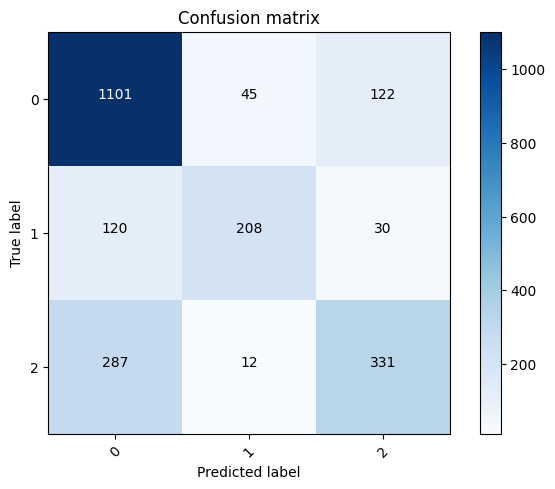

In [31]:
#Evaluate model and print results
#==============================================================================

CNN_History=model.fit(x_train, y_train, epochs = 5, batch_size = 256,verbose=1, validation_data=(x_val,y_val), shuffle=True)

plot_history(CNN_History)

full_multiclass_report(model, x_val, y_val, encoder.inverse_transform(np.arange(3)))


Architecture adapted and database sourced from: https://github.com/lule-ahmedi/AlbAna/